# Building and Optimizing a Portfolio in Python



This Python notebook serves as a guide to constructing and enhancing investment portfolios. I will delve into two powerful optimization models: **the Markowitz Mean-Variance Optimization Model** and **the Black-Litterman Allocation Model**.

By leveraging these models, I aim to:

*   *Construct diversified portfolios* : Reduce risk through effective asset
allocation.
*   *Optimize risk-return trade-offs* : Balance the pursuit of higher returns with acceptable risk levels.
*   *Incorporate investor views* : Account for individual preferences and market insights.

To do this, we use the four tech giants Apple, AMD, Disney and Tesla as examples to build our portfolio.


In [1]:
#install dependencies
!pip install yfinance
!pip install quantstats
!pip install pyportfolioopt
!pip install ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=664b97ed5377e5cc444648199ddcb189358c30edfceeda5a95b506431ee60363
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
# Importing Libraries

# Data handling and statistical analysis
import pandas as pd
from pandas_datareader import data
import numpy as np
from scipy import stats

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib import rcParams

# Financial data
import quantstats as qs
import ta
import yfinance as yf

# Enabling Plotly offline
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Datetime and hiding warnings
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
import logging

# Optimization and allocation
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import black_litterman, BlackLittermanModel

## Building a Portfolio

To start exploring portfolio construction and optimization, we ought to build a portfolio consisting of the four stocks that have been analyzed so far, with an initial weighting of 25% each.

The four stocks of choice are: Apple, Tesla, AMD and Disney with the benchmark being the SP500.

In [3]:
#getting daily returns for 4 different US stocks + benchmark in the same time window
aapl = qs.utils.download_returns('AAPL')
aapl = aapl.loc['2014-07-01':'2024-06-15']

tsla = qs.utils.download_returns('TSLA')
tsla = tsla.loc['2014-07-01':'2024-06-15']

dis = qs.utils.download_returns('DIS')
dis = dis.loc['2014-07-01':'2024-06-15']

amd = qs.utils.download_returns('AMD')
amd = amd.loc['2014-07-01':'2024-06-15']

sp500 = qs.utils.download_returns('^GSPC')
sp500 = sp500.loc['2014-07-01':'2024-06-15']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
#defining weights for each stock
weights = [0.25, 0.25, 0.25, 0.25]

#creating a portfolio by multiplying each stock with its respective weight
portfolio = aapl*weights[0] + tsla*weights[1] + dis*weights[2] + amd*weights[3]
portfolio

,Close
Date,
2014-07-01,0.005152
2014-07-02,-0.003816
2014-07-03,-0.003329
2014-07-07,-0.001569
2014-07-08,-0.010101
...,...
2024-06-10,-0.018244
2024-06-11,0.006958
2024-06-12,0.018696


[Performance Metrics]

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2014-07-01   2014-07-01
End Period                 2024-06-14   2024-06-14
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          177.09%      1,271.58%
CAGR﹪                     7.32%        19.9%

Sharpe                     0.67         1.0
Prob. Sharpe Ratio         98.08%       99.92%
Smart Sharpe               0.64         0.96
Sortino                    0.93         1.47
Smart Sortino              0.89         1.4
Sortino/√2                 0.66         1.04
Smart Sortino/√2           0.63         0.99
Omega                      1.19         1.19

Max Drawdown               -33.92%      -52.28%
Longest DD Days            745          893
Volatility (ann.)          17.77%       31.04%
R^2                        0.56         0.56
Information Ratio          0.06         0

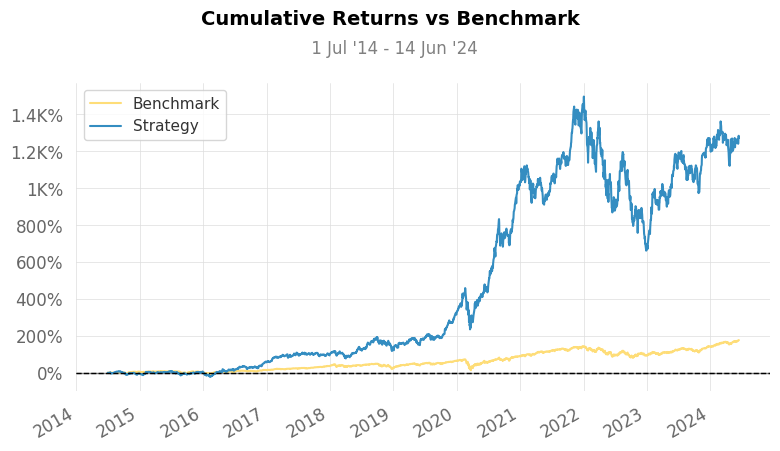

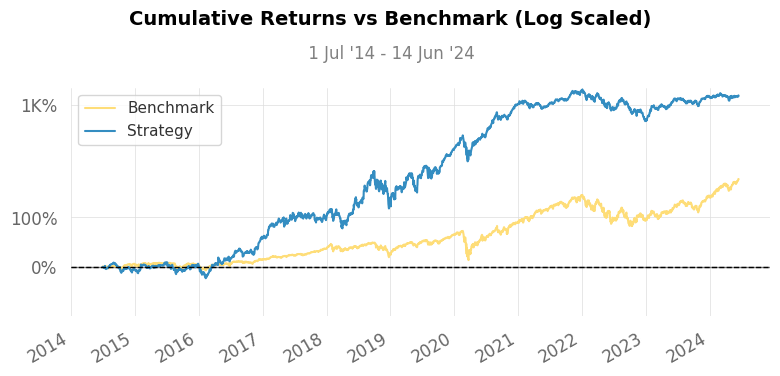

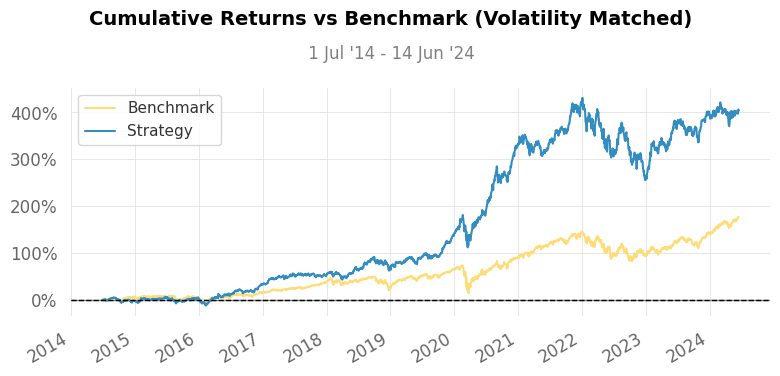

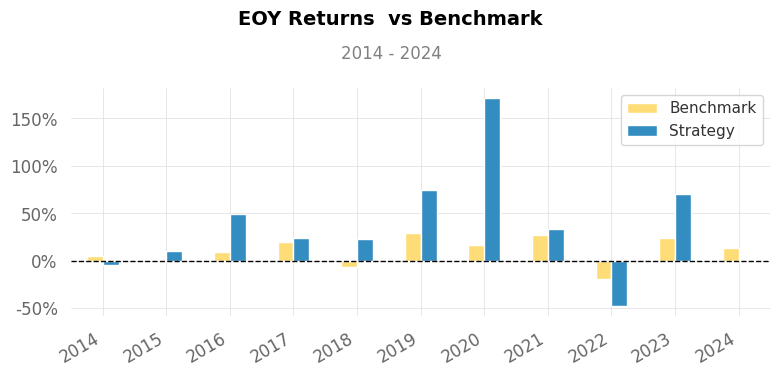

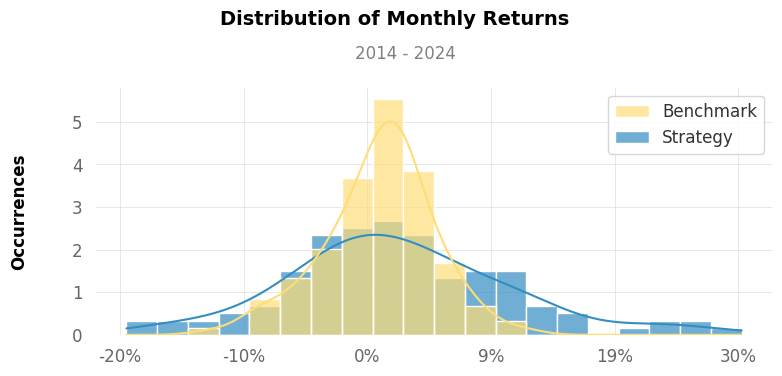

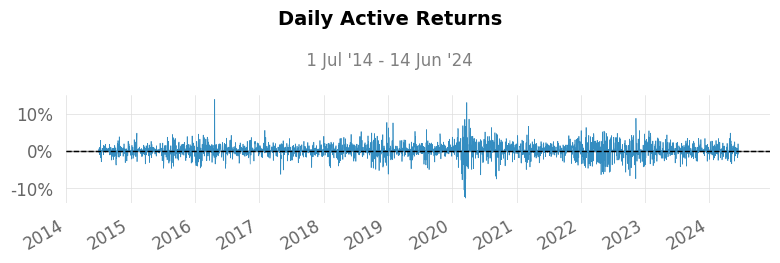

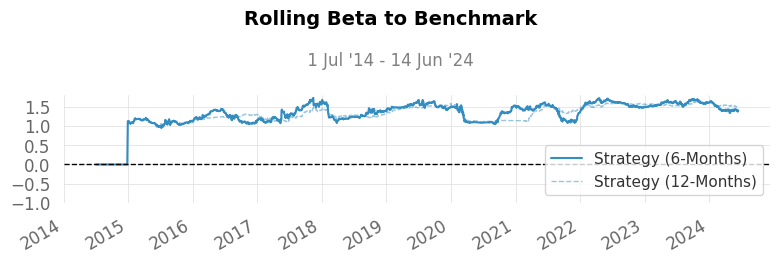

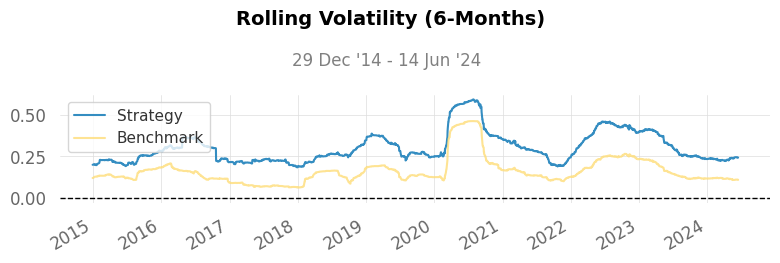

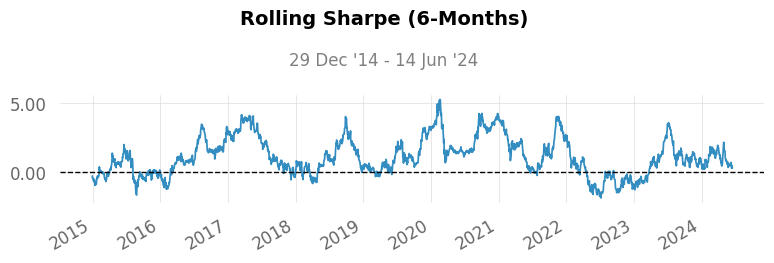

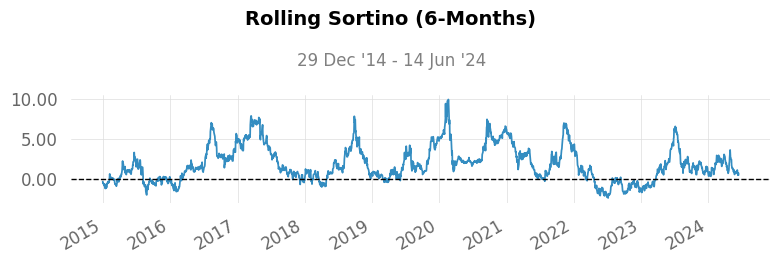

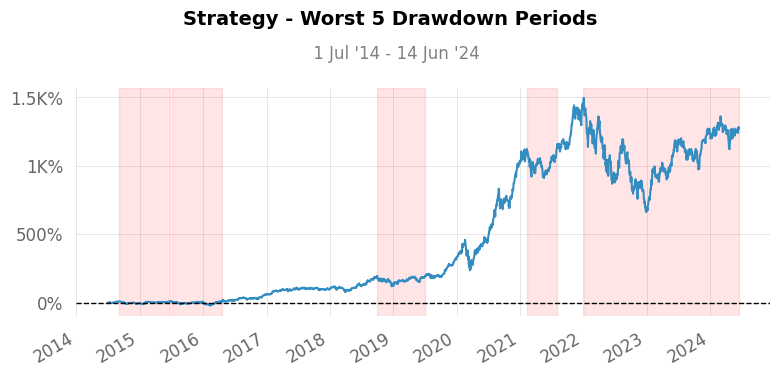

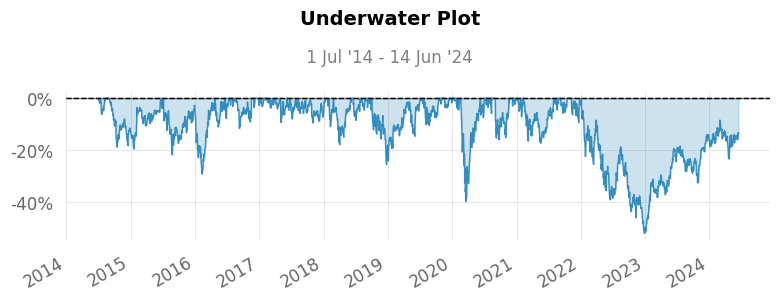

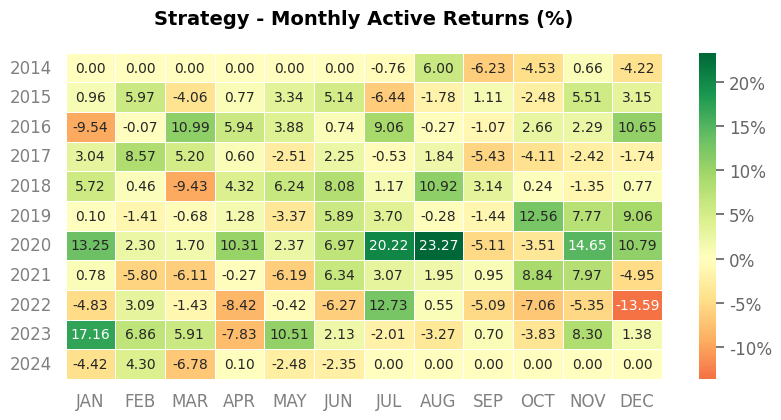

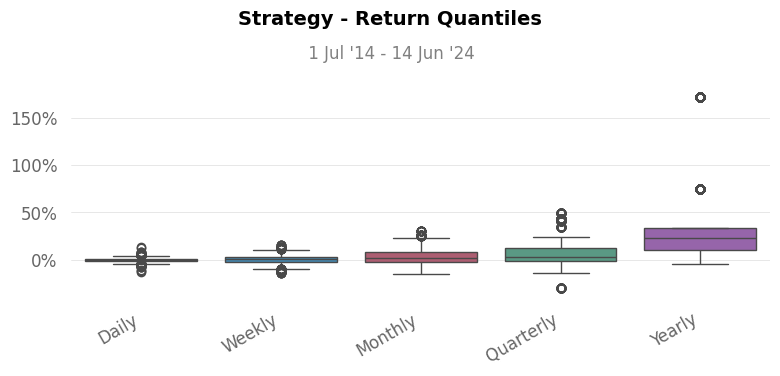

In [5]:
#generating full report on portfolio performance
qs.reports.full(portfolio, benchmark = sp500)

We have a range of metrics and plots available to look at. Firstly, the Cumulative Return of the portfolio is higher than the benchmark, at 1,271.58% compared to 177.09% for the SP500. The Sharpe Ratio and Sortino Ratio of the portfolio are also higher, indicating that it generates better returns for the level of risk taken. In addition, the portfolio has higher expected daily, monthly and annual returns than the SP500, and its best day, month, and year outperforms the benchmark's best day, month, and year.


While the portfolio has higher returns on its best day, month, and year, it also has bigger losses on its worst day, month, and year compared to the benchmark. The beta of 1.31 shows that the portfolio is about 31% more volatile than the overall market, and its 75.14% correlation indicates a strong positive relationship among the four stocks, suggesting that they tend to move in the same direction, which could increase the systemic risk of the portfolio.

## Optimizing a Portfolio

Portfolio optimization is the art of crafting the best possible mix of assets and their proportions to achieve maximum returns while keeping risks in check. This involves carefully weighing each asset based on its past performance, how it interacts with other assets, and external factors like market trends and economic forecasts. The ultimate aim is to build a diversified portfolio that strikes a balance between risk and reward, aligning perfectly with the investor's comfort level with risk.

To kick off the optimization process, we need a Pandas DataFrame that lists the adjusted closing prices of the stocks. This DataFrame should have dates as its index and each column representing a different stock. It will serve as the foundation for determining the ideal weights for each stock within the portfolio.

In [6]:
#getting dataframes info for stocks using yfinance
aapl_df = yf.download('AAPL', start = '2014-07-01', end = '2024-06-15')
tsla_df = yf.download('TSLA', start = '2014-07-01', end = '2024-06-15')
dis_df = yf.download('DIS', start = '2014-07-01', end = '2024-06-15')
amd_df = yf.download('AMD', start = '2014-07-01', end = '2024-06-15')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
#extracting Adjusted Close for each stock
aapl_df = aapl_df['Adj Close']
tsla_df = tsla_df['Adj Close']
dis_df = dis_df['Adj Close']
amd_df = amd_df['Adj Close']

In [8]:
#merging and creating an Adj Close dataframe for stocks
df = pd.concat([aapl_df, tsla_df, dis_df, amd_df], join = 'outer', axis = 1)
df.columns = ['aapl', 'tsla', 'dis', 'amd']
df

,aapl,tsla,dis,amd
Date,,,,
2014-07-01,20.656525,15.981333,78.956963,4.220000
2014-07-02,20.647690,15.295333,78.929573,4.340000
2014-07-03,20.769175,15.283333,79.294785,4.240000
2014-07-07,21.197674,14.844000,79.066521,4.260000
2014-07-08,21.060736,14.604667,78.399979,4.220000
...,...,...,...,...
2024-06-10,192.896713,173.789993,102.268188,160.339996
2024-06-11,206.910492,170.660004,100.406776,158.960007
2024-06-12,212.823669,177.289993,100.337097,160.240005


### Markowitz Mean-Variance Optimization Model

The Markowitz Mean-Variance Optimization Model is a popular framework for building investment portfolios that balance risk and reward effectively. It's rooted in the idea that investors should aim for the highest possible returns while keeping risks in check.

To start, we need to estimate how much we expect each asset in the portfolio to earn. PyPortfolioOpt's expected_returns module helps us do this by calculating average daily percentage changes. It assumes we have daily price data and gives us annualized expected returns.

Next, we need to measure the risk associated with each asset. The most common way is using a covariance matrix, which shows how much an asset's price fluctuates and how it moves in relation to other assets. Choosing the right risk model is crucial because it can help us diversify our investments and reduce overall risk. PyPortfolioOpt offers several options, including the standard covariance matrix, semicovariance matrix, and a matrix that weights recent returns more heavily.

In [9]:
#calculating the annualized expected returns and the annualized sample covariance matrix

#expected returns
mu = expected_returns.mean_historical_return(df)

#covariance matrix
S = risk_models.sample_cov(df)

In [10]:
#view mu
mu

,0
aapl,0.263989
tsla,0.274289
dis,0.023538
amd,0.440992


In [12]:
#view S
S

,aapl,tsla,dis,amd
aapl,0.081048,0.067129,0.033181,0.068794
tsla,0.067129,0.309040,0.044724,0.107847
dis,0.033181,0.044724,0.076392,0.044987
amd,0.068794,0.107847,0.044987,0.341886


In [13]:
#optimizing for maximal Sharpe ratio

#providing expected returns and covariance matrix as input
ef = EfficientFrontier(mu, S)

#optimizing weights for Sharpe ratio maximization
weights = ef.max_sharpe()

#clean_weights rounds the weights and clips near-zeros
clean_weights = ef.clean_weights()
clean_weights

OrderedDict([('aapl', 0.74433),
             ('tsla', 0.01806),
             ('dis', 0.0),
             ('amd', 0.2376)])

In [15]:
#creating new portfolio with optimized weights

new_weights = [0.74433, 0.01806, 0.2376]
optimized_portfolio = aapl*new_weights[0] + tsla*new_weights[1] + amd*new_weights[2]
optimized_portfolio

,Close
Date,
2014-07-01,0.006401
2014-07-02,0.005663
2014-07-03,-0.001110
2014-07-07,0.015958
2014-07-08,-0.007331
...,...
2024-06-10,-0.025286
2024-06-11,0.051705
2024-06-12,0.023887


[Performance Metrics]

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2014-07-01   2014-07-01
End Period                 2024-06-14   2024-06-14
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          1,271.58%    1,584.75%
CAGR﹪                     19.9%        21.62%

Sharpe                     1.0          1.09
Prob. Sharpe Ratio         99.92%       99.97%
Smart Sharpe               0.93         1.01
Sortino                    1.47         1.61
Smart Sortino              1.36         1.49
Sortino/√2                 1.04         1.14
Smart Sortino/√2           0.96         1.05
Omega                      1.21         1.21

Max Drawdown               -52.28%      -38.93%
Longest DD Days            893          542
Volatility (ann.)          31.04%       30.22%
R^2                        0.77         0.77
Information Ratio          0.01       

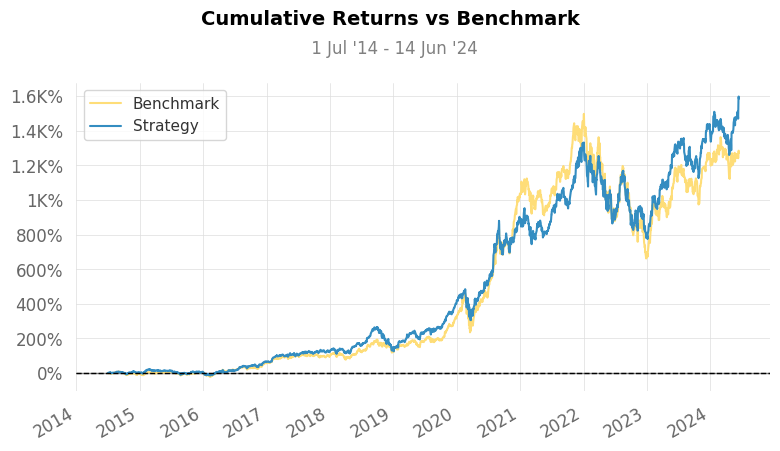

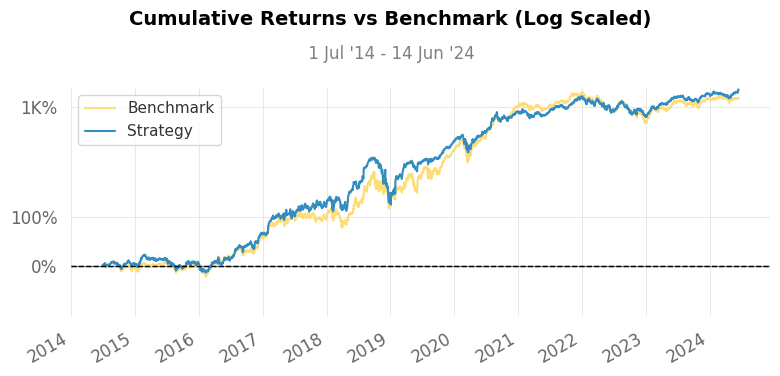

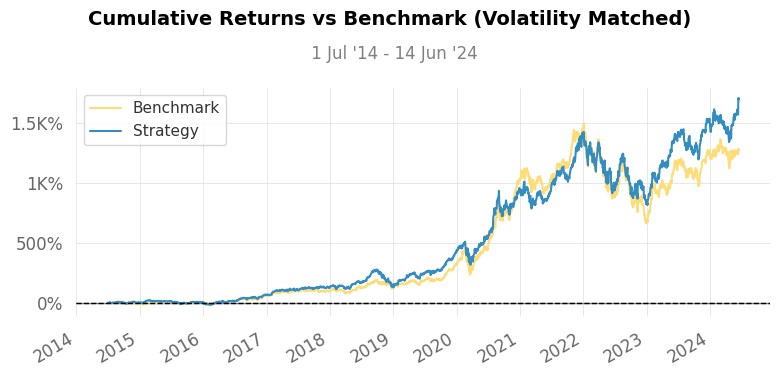

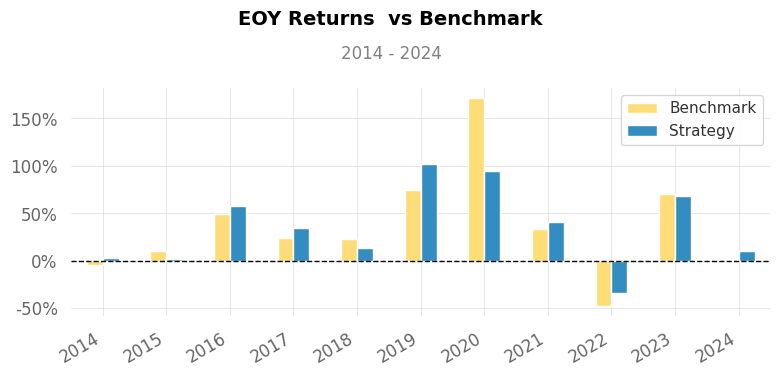

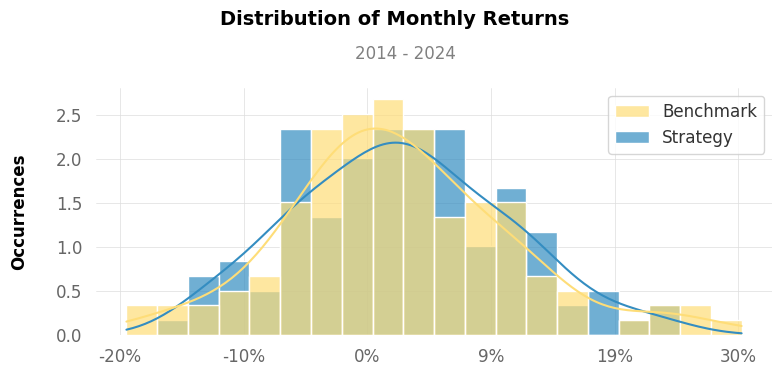

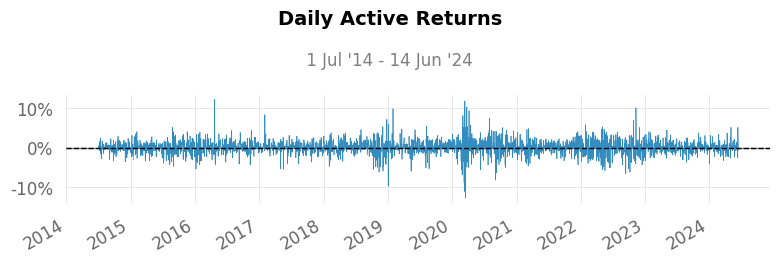

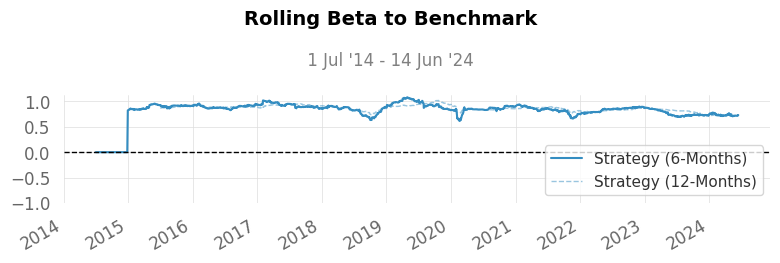

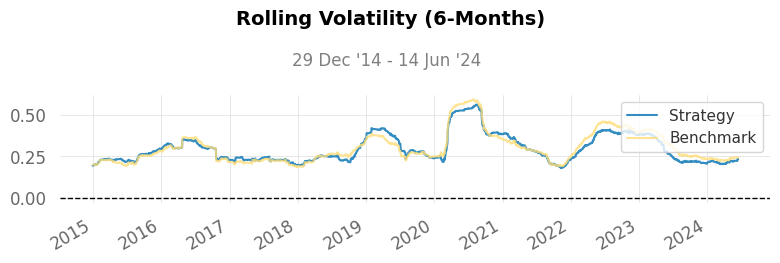

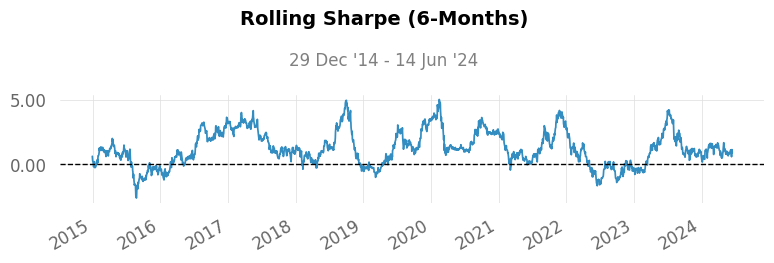

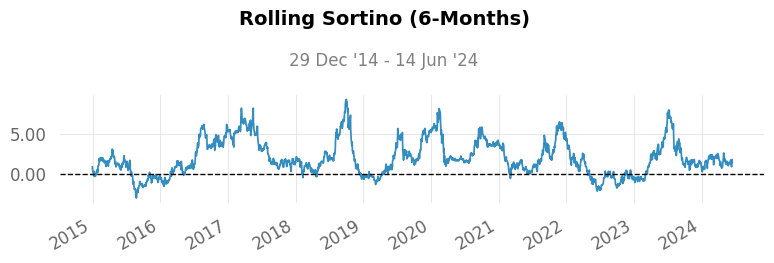

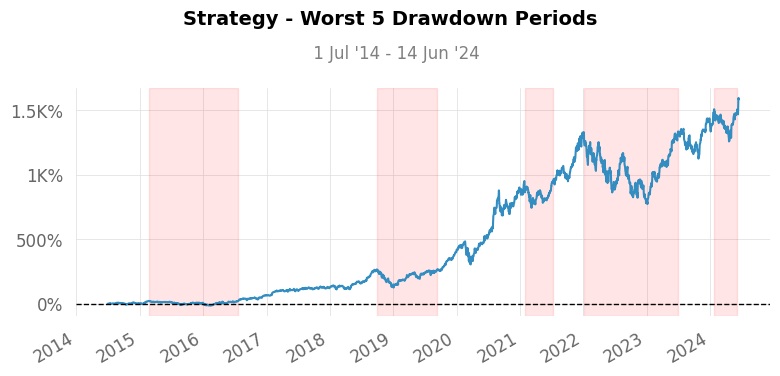

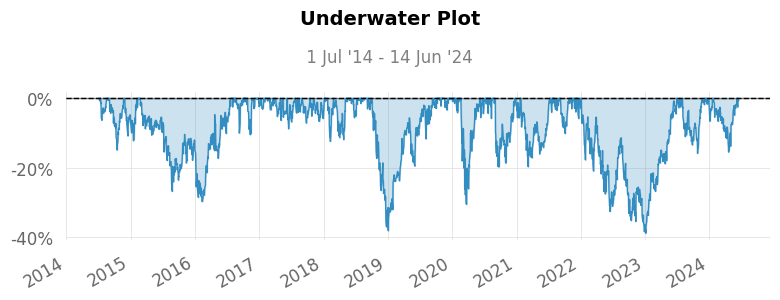

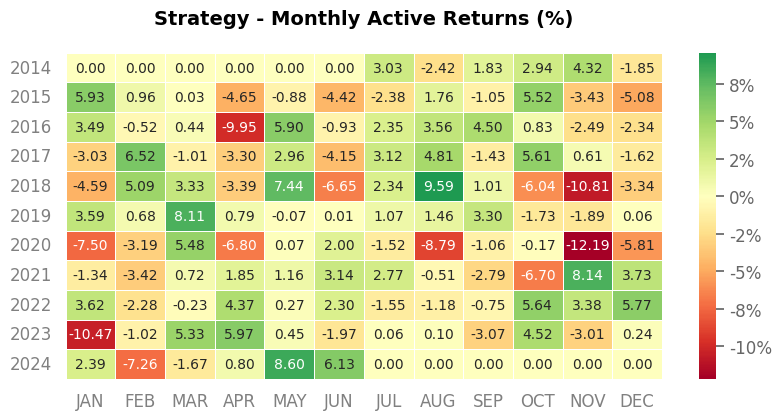

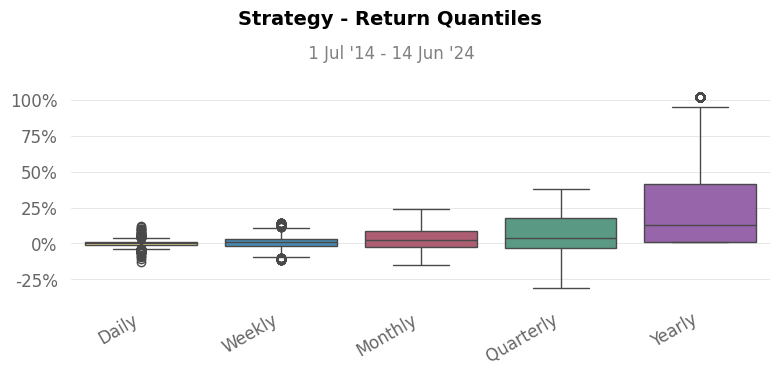

In [16]:
#generating report comparing the optimized portfolio to the first portfolio constructed
qs.reports.full(optimized_portfolio, benchmark = portfolio)

Based on the report above, the optimized portfolio appears to have performed better than the original portfolio. Here are some key conclusions that can be drawn by looking at the metrics and plots in the report:


*Cumulative Return* : The optimized portfolio has generated a slightly higher cumulative return of 1,584.75% compared to 1,271.58%  for the original portfolio. This means that the an investment in the optimized portfolio would have provided higher earnings for investors compared to the original portfolio.


*CAGR* : The compounded annual growth rate (CAGR) of the optimized portfolio is higher at 21.62% compared to 19.9% for the original portfolio. This suggests that the optimized portfolio has generated a higher rate of return per year over the entire investment period.


*Sharpe Ratio* : The optimized portfolio has a very slightly higher Sharpe ratio of 1.09 compared to 1.0 for the original portfolio, indicating that it has generated a better risk-adjusted return.


*Recovery Factor* : The recovery factor for the optimized portfolio is slightly higher at 8.43 compared to 5.93 for the original portfolio, which suggests that the optimized portfolio was able to recover from drawdowns more quickly and generate slighlty higher returns after experiencing losses.


*Win Rates* : The optimized portfolio has slightly higher win rates for win days, win months, win quarters, and win years, indicating that it had a higher probability of generating positive returns over these periods.


*Beta* : The optimized portfolio's beta of 0.86 indicates that the optimized portfolio is less volatile than the overall market, and much less volatile than the previously built portfolio.


*Annual Volatility* : The optimized portfolio has a slightly lower annual volatility than the original portfolio, with 30.22% compared to 31.04%, respectively.

### Black-Litterman Allocation Model

The Black-Litterman Allocation Model is a sophisticated approach to investing that combines a prior estimate of returns with an investor's own beliefs. It uses a Bayesian framework to balance these two sources of information and find the optimal asset allocation.

First, we need a prior estimate of expected returns. Often, we use market expectations, which are reflected in the market capitalization of assets. To calculate this, we need to estimate market risk aversion, represented by a parameter called "delta." We can get this from the S&P 500's closing prices.

Next, investors express their own views on returns. These can be absolute (like "AAPL will return 10%") or relative (like "AMZN will outperform AMD"). We represent these views in a vector "Q" and map them to specific assets using a "picking matrix" "P."

How much weight we give to these views depends on how confident we are in them. We use a "confidence matrix" to express this confidence. Higher values mean more confidence.

The Black-Litterman model then combines our prior estimate and our personal views, weighted according to our confidence levels. This gives us a more informed and personalized allocation for our portfolio.

In [17]:
#name of tickers in portfolio
assets = ['AAPL', 'TSLA', 'DIS', 'AMD']

In [26]:
#obtaining market cap for stocks

#function to get market cap
def get_market_cap(ticker):
    market_cap = yf.Ticker(ticker).info['marketCap']
    return market_cap

#create an empty DataFrame to store results
market_caps = pd.DataFrame(columns=['Ticker', 'Market Cap'])

#get market cap for each ticker in assets and append to dataframe
for ticker in assets:
    market_cap = get_market_cap(ticker)
    new_row = pd.DataFrame({'Ticker': [ticker], 'Market Cap': [market_cap]})
    market_caps = pd.concat([market_caps, new_row], ignore_index=True)  # Concatenate

market_caps

,Ticker,Market Cap
0,AAPL,3357369434112
1,TSLA,673206435840
2,DIS,159487115264
3,AMD,217442795520


In [27]:
#obtaining closing prices for the SP500
market_prices = yf.download("^GSPC", start = '2014-07-01', end = '2024-06-15')['Adj Close']
market_prices

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2014-07-01,1973.319946
2014-07-02,1974.619995
2014-07-03,1985.439941
2014-07-07,1977.650024
2014-07-08,1963.709961
...,...
2024-06-10,5360.790039
2024-06-11,5375.319824
2024-06-12,5421.029785


In [28]:
#obtaining market-implied risk aversion, the delta
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

3.0938529921080007

In [29]:
#view S
S

,aapl,tsla,dis,amd
aapl,0.081048,0.067129,0.033181,0.068794
tsla,0.067129,0.309040,0.044724,0.107847
dis,0.033181,0.044724,0.076392,0.044987
amd,0.068794,0.107847,0.044987,0.341886


In [40]:
#changing columns and index to uppercase so it matches market_caps
S.index = S.index.str.upper()
S.columns = S.columns.str.upper()
S

,AAPL,TSLA,DIS,AMD
AAPL,0.081048,0.067129,0.033181,0.068794
TSLA,0.067129,0.309040,0.044724,0.107847
DIS,0.033181,0.044724,0.076392,0.044987
AMD,0.068794,0.107847,0.044987,0.341886


In [44]:
# Obtaining Prior estimates

#check if 'Ticker' is already the index, if not make it
if 'Ticker' in market_caps.columns:
    market_caps.set_index('Ticker', inplace=True)

#convert the 'Market Cap' column to a series
market_caps_series = market_caps['Market Cap'].astype('int64')

#ensure both market_caps_series and S are in the same order
market_caps_series = market_caps_series.reindex(S.index)

#calculate priors
prior = black_litterman.market_implied_prior_returns(market_caps_series, delta, S)
prior

,0
AAPL,0.256943
TSLA,0.345711
DIS,0.134751
AMD,0.290312


In [45]:
#define Predictions (investor views)

# APPL will raise by 5%
# TSLA will raise by 10%
# AMD will outperform Disney by 15%

Q = np.array([0.05, 0.10, 0.15])

In [46]:
#linking views to assets

P = np.array([
    [1,0,0,0], #APPL = 0.05
    [0,1,0,0], #TSLA = 0.10
    [0,0,-1,1] #AMD > DIS by 0.15
])

In [47]:
#providing confidence levels for each view
#0.0 = low confidence, 1.0 = high confidence

confidences = [0.5,
               0.4,
               0.8]

In [48]:
#creating model
bl = BlackLittermanModel(S,
                         pi = prior,
                         Q = Q,
                         P = P,
                         omega = 'idzorek', #method to estimate uncertainty level of the views based on historical data
                         view_confidences = confidences)

In [49]:
#calculating Expected returns
rets = bl.bl_returns()

#optimizing asset allocation
ef = EfficientFrontier(rets, S)

In [50]:
#optimizing weights for maximal Sharpe ratio
ef.max_sharpe()

#cleaning weights
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.68407),
             ('TSLA', 0.14922),
             ('DIS', 0.0),
             ('AMD', 0.16671)])

In [52]:
#building Black-Litterman portfolio
black_litterman_weights = [0.68407,
                          0.14922,
                          0.0,
                          0.16671]
black_litterman_portfolio = aapl*black_litterman_weights[0] + tsla*black_litterman_weights[1] + dis*black_litterman_weights[2] + amd*black_litterman_weights[3]

In [53]:
black_litterman_portfolio

,Close
Date,
2014-07-01,0.005325
2014-07-02,-0.001957
2014-07-03,0.000066
2014-07-07,0.010610
2014-07-08,-0.008391
...,...
2024-06-10,-0.023679
2024-06-11,0.045575
2024-06-12,0.026689


[Performance Metrics]

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2014-07-01   2014-07-01
End Period                 2024-06-14   2024-06-14
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          1,271.58%    1,574.18%
CAGR﹪                     19.9%        21.57%

Sharpe                     1.0          1.1
Prob. Sharpe Ratio         99.92%       99.97%
Smart Sharpe               0.94         1.03
Sortino                    1.47         1.6
Smart Sortino              1.38         1.5
Sortino/√2                 1.04         1.13
Smart Sortino/√2           0.97         1.06
Omega                      1.21         1.21

Max Drawdown               -52.28%      -43.31%
Longest DD Days            893          561
Volatility (ann.)          31.04%       29.84%
R^2                        0.86         0.86
Information Ratio          0.01         0

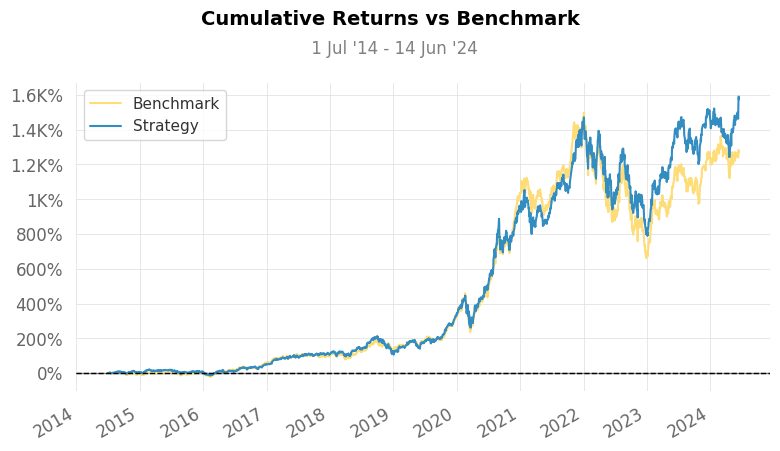

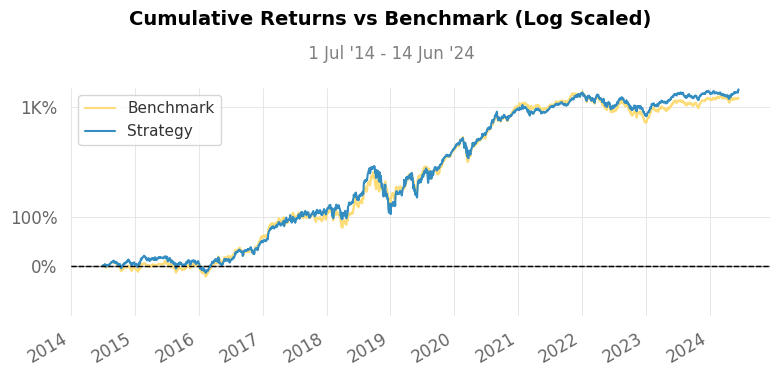

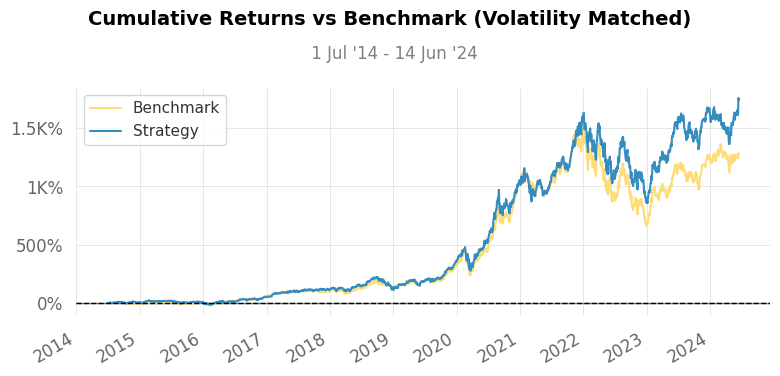

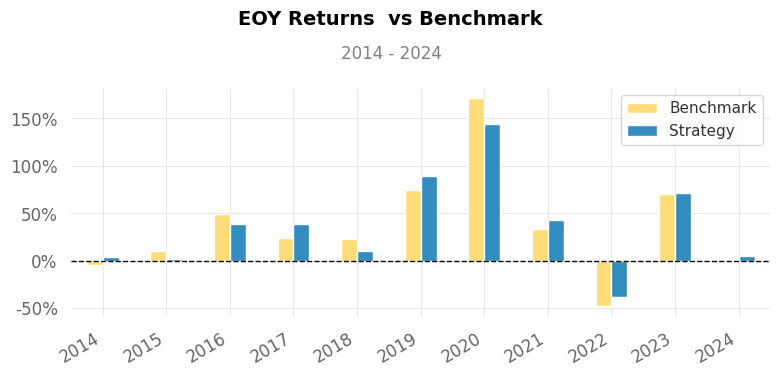

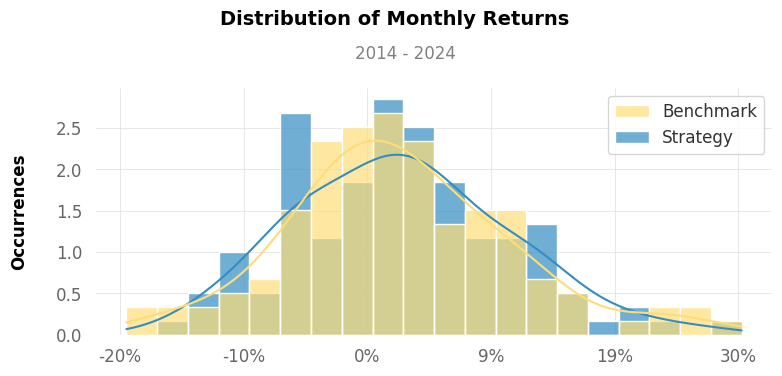

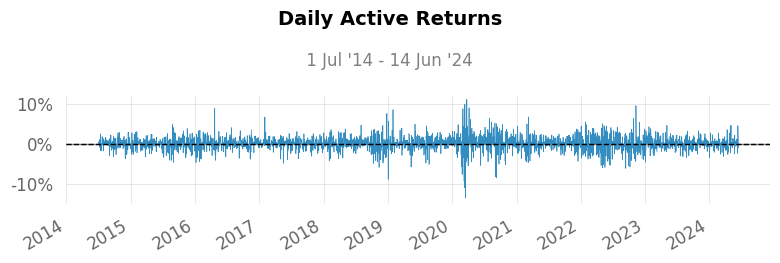

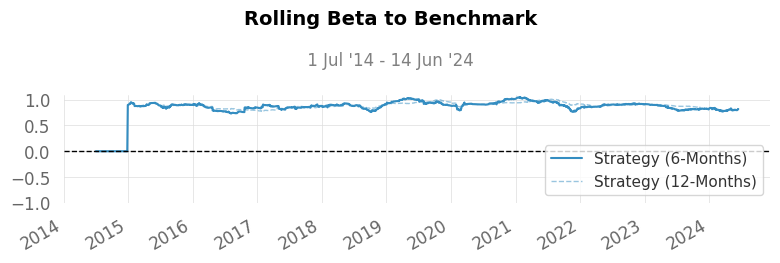

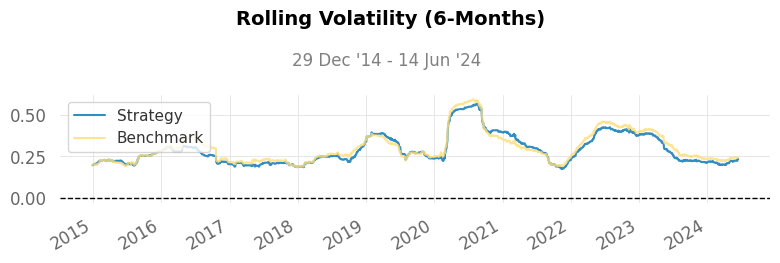

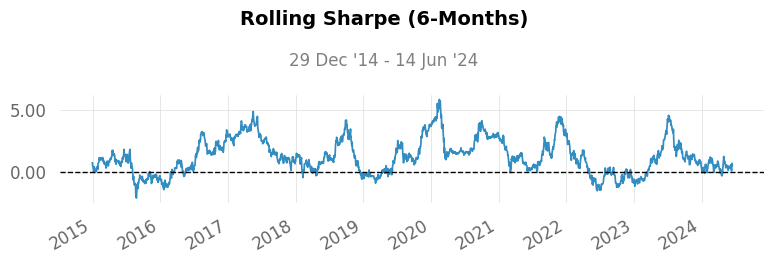

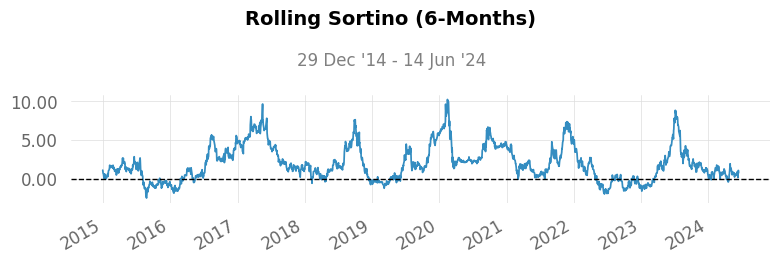

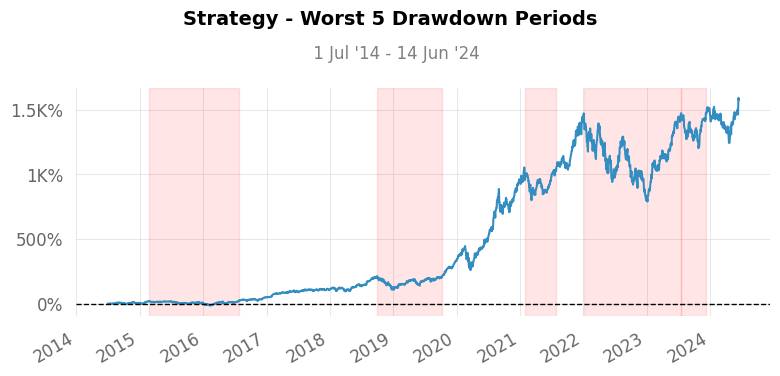

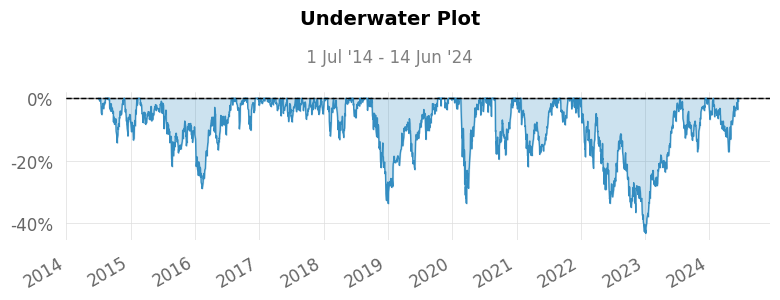

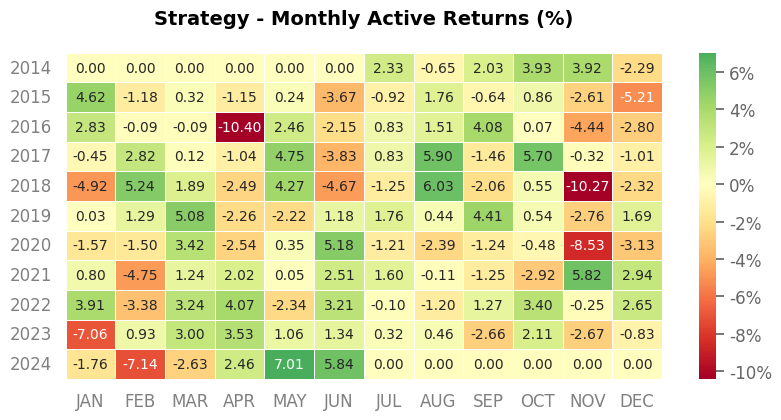

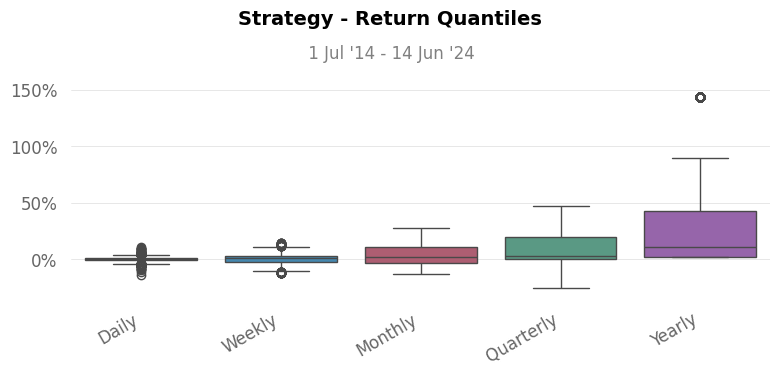

In [54]:
#comparing Black-Litterman portfolio to the original portfolio
qs.reports.full(black_litterman_portfolio, benchmark = portfolio)

By using the Black-Litterman Allocation Model, we were able to improve our investment portfolio's performance metrics compared to the original portfolio, where each asset was allocated a uniform weight of 25%. The Black-Litterman optimized portfolio outperformed the original portfolio in several key metrics. First, it generated higher cumulative return and CAGR, indicating a stronger overall performance. Additionally, the Sharpe and Sortino ratios were slightly higher, demonstrating greater risk-adjusted returns.

The Black-Litterman portfolio had a lower averaged drawdown and higher recovery factor, meaning that it can bounce back faster from losses, and the beta of the optimized portfolio was much lower than that of the original portfolio, indicating lower overall market risk. Overall, the Black-Litterman optimized portfolio achieved higher returns at lower risks.

## Conclusion

Both the Markowitz Mean-Variance Model and the Black-Litterman Allocation Model significantly improved the performance of our original portfolio, reducing risk and optimizing the allocation of Apple, Tesla, Disney, and AMD stocks.

The Markowitz model favored Apple and Tesla, while Black-Litterman spread investments across all four stocks, though Apple still held a significant portion.

Black-Litterman demonstrated some advantages, including lower maximum losses, reduced volatility, and better performance during downturns. However, Markowitz still outperformed in terms of overall annual losses.

Portfolio optimization is a crucial step in enhancing risk-return relationships. By adjusting asset allocations using mathematical models and optimization techniques, we can effectively improve performance and mitigate risks.

While both Markowitz and Black-Litterman offer valuable approaches, the best choice depends on individual risk tolerance, investment goals, and market conditions. There's no one-size-fits-all solution to portfolio optimization.